### Importing Libraries

In [1]:
## Common python packages
import numpy as np
import pandas as pd

## For plotting
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")
sns.set_color_codes()

## sklearn - ML tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve
from sklearn.utils import resample, shuffle
from sklearn.preprocessing import OneHotEncoder

from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool

## weighted stats
from statsmodels.stats.weightstats import DescrStatsW

## "-" sign for graphs
rcParams['axes.unicode_minus'] = False

## Some extra styling
def namestr(obj, namespace = globals()):
    "Prints the name of a variable"
    return [name for name in namespace if namespace[name] is obj][0]

## For time
from dateutil.relativedelta import relativedelta

## For country encoding
from dataprep.clean import clean_country

### Preliminary tools for data analysis

In [2]:
## Univar Tools
def data_stats(df, cols = None):
    cols = df.columns if cols is None else cols
    return pd.DataFrame({"Mean": df[cols].mean, "Med": df[cols].median(), "STD": df[cols].std, 
                         "Min": df[cols].min(), "Max": df[cols].max()})
              
def hist_plotter(df, cols = None, range_x = None, n_std = 1, size = None, nbin = 100):
    cols = df.select_dtypes(include=np.number).columns if cols is None else cols
    for col in cols:
        range_ = [df[col].min() + n_std * df[col].std(), df[col].max() - n_std * df[col].std()] if range_x is None else range_x
        fig, ax = plt.subplots(1,1)
        df[col].plot(kind = "hist", range = range_, edgecolor = "blue", alpha = 1, bins = nbin, density = 1, ax = ax, figsize = size)
        plt.xlabel(col)
        plt.show()
    
def box_plotter(df, cols = None):
    cols = df.columns if cols is None else cols
    fig, ax = plt.subplots(1, 1)
    df[cols].boxplot(ax=ax)
    plt.xticks(rotation = 90)
    plt.show()
    
## Bivar Tools
def data_corr(df, size = None, cols = None):
    cols = df.columns if cols is None else cols 
    size = (len(cols), len(cols)) if size is None else size
    plt.figure(figsize = size)
    sns.heatmap(df.corr(), cmap = "coolwarm", square = True, vmin = -1, vmax = 1, annot=True)
    plt.show()
        
## For date conversion
month_lib = {
    "jan": 0,
    "feb": 1,    
    "mar": 2,
    "apr": 3,    
    "may": 4,
    "jun": 5,    
    "jul": 6,
    "aug": 7,    
    "sep": 8,
    "oct": 9,    
    "nov": 10,
    "dec": 11
}

### Processing the train data

In [3]:
df = pd.read_csv("datasets_hi4/train-data.csv", sep=";")

df["Country"] = df["Country"].str.upper()

date = df["Date"].str.split(n=1, expand=True)
df["Year"] = date[1]
df["Trisem"] = pd.to_numeric(date[0].str.slice(stop=3).replace(month_lib))//3
df["Trisem"] = df["Trisem"].astype(str)

df.drop_duplicates(inplace=True)

for col in ["Month 1", "Month 2", "Month 3", "Month 4"]:
    df[col] = pd.to_numeric(df[col].str.replace(" ", ""))
       
#df['Month 1'] = df.groupby('Strategic Product Family proxy')['Month 1'].transform(lambda x: x.fillna(x.mean()))
df["Product Life cycel status"] = df["Product Life cycel status"].fillna("ACT")

### Processing Additional Data

#### GSCPI

In [4]:
df_GSCPI = pd.read_csv("datasets_hi4/extra-dataset/GSCPI_data.csv")

print(df_GSCPI.shape)

df_GSCPI["Year"] = df_GSCPI["Year-Month"].str.slice(stop=4)
df_GSCPI["Trisem"] = pd.to_numeric(df_GSCPI["Year-Month"].str.slice(start=5))//3
df_GSCPI["Trisem"] = df_GSCPI["Trisem"].astype(str)

df_GSCPI = df_GSCPI.groupby(["Year", "Trisem"], as_index=False)["GSCPI"].mean()

print(df_GSCPI.shape)

(43, 2)
(18, 3)


#### LPI

In [5]:
df_LPI = pd.read_csv("datasets_hi4/extra-dataset/LPIextend.csv")

cols = []
for col in df_LPI.columns:
    if "Score" in col:
            cols.append(col)
            
df_LPI["LogPerf"] = df_LPI[cols].mean(axis=1)
df_LPI = df_LPI.replace('TC<rkiye',"Turkey")
df_LPI = clean_country(df_LPI, "Country", output_format="alpha-2", inplace=True)
df_LPI["Country_clean"] = df_LPI["Country_clean"].fillna('NA')

df_LPI = df_LPI[["Country_clean", "LogPerf"]].rename(columns={"Country_clean": "Country"}) 
df_LPI["LogPerf"] = df_LPI["LogPerf"].transform(lambda x: x.fillna(x.mean() - (1/5) * x.std()))

df_LPI = df_LPI.drop_duplicates(subset = ["Country"])

C:\Users\alper\anaconda3\Lib\site-packages\dask\dataframe\core.py:7067: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(


  0%|                                                                                            | 0/8 [00:00<…

Country Cleaning Report:
	249 values cleaned (99.6%)
	1 values unable to be parsed (0.4%), set to NaN
Result contains 249 (99.6%) values in the correct format and 1 null values (0.4%)


#### Infilation Data (Later Dropped)

In [6]:
df_inf = pd.read_csv("datasets_hi4/extra-dataset/worldbank_inflation_data.csv")

inf_years = np.array(list(map(lambda x: x.split('-')[0], df_inf["Year-Month"].to_list())))
inf_months = np.array(list(map(lambda x: int(x.split('-')[1]), df_inf["Year-Month"].to_list())))

df_inf["Year"] = inf_years
df_inf["Trisem"] = list(map(str, (inf_months - 1)//4))

df_inf = df_inf.replace('SÃ£o TomÃ© and Principe',"Sao Tome and Principe")
df_inf = clean_country(df_inf, "Country", output_format="alpha-2")
df_inf.drop(columns = ['Country', 'Year-Month'], inplace = True)
df_inf.rename(columns = {"Country_clean": "Country"}, inplace = True)
df_inf["Country"] = df_inf["Country"].fillna('NA')

df_inf["Energy Price Index"] = df_inf["Energy Price Index"].transform(lambda x: x.fillna(x.mean()))
df_inf["Headline Consumer Price Index"] = df_inf["Headline Consumer Price Index"].transform(lambda x: x.fillna(x.mean()))

dfi_grouped = df_inf.groupby(["Year", "Trisem", "Country"])["Energy Price Index", "Headline Consumer Price Index"].mean()

C:\Users\alper\anaconda3\Lib\site-packages\dask\dataframe\core.py:7067: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(


  0%|                                                                                            | 0/8 [00:00<…

Country Cleaning Report:
	8084 values cleaned (99.47%)
	43 values unable to be parsed (0.53%), set to NaN
Result contains 8084 (99.47%) values in the correct format and 43 null values (0.53%)


C:\Users\alper\AppData\Local\Temp\ipykernel_3288\2549750652.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dfi_grouped = df_inf.groupby(["Year", "Trisem", "Country"])["Energy Price Index", "Headline Consumer Price Index"].mean()


#### CO2 (EPI) Data

In [7]:
df_epi = pd.read_csv("datasets_hi4/extra-dataset/epi2022results05302022.csv")

df_epi = clean_country(df_epi, "country", output_format="alpha-2", inplace=True)
df_epi = df_epi[["country_clean", "SDA.new", "NXA.new", "CDA.new", "CHA.new", "NDA.new",
                 "BCA.new", "GIB.new", "GHP.new"]]
df_epi = df_epi.rename(columns = {"country_clean": "Country"})
df_epi["EmAv"] = df_epi[["NXA.new", "CDA.new", "SDA.new", "BCA.new", "NDA.new"]].mean(axis=1)
df_epi = df_epi.drop(["NXA.new","CDA.new","SDA.new","BCA.new","NDA.new"],axis=1)

df_epi["Country"] = df_epi["Country"].fillna('NA')
df_epi = df_epi.drop_duplicates(subset = ["Country"])

C:\Users\alper\anaconda3\Lib\site-packages\dask\dataframe\core.py:7067: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(


  0%|                                                                                            | 0/8 [00:00<…

Country Cleaning Report:
	179 values cleaned (99.44%)
	1 values unable to be parsed (0.56%), set to NaN
Result contains 179 (99.44%) values in the correct format and 1 null values (0.56%)


#### Economic Data

In [8]:
df_econ = pd.read_csv("datasets_hi4/extra-dataset/worldbank_economic_data.csv")

df_econ = df_econ[df_econ["Country"].str.contains("Macao")==False ]

df_econ = df_econ.replace('Turkiye',"Turkey")
df_econ = clean_country(df_econ, "Country", output_format="alpha-2")
df_econ = df_econ.dropna(subset = "Country_clean")
df_econ.drop(columns = ['Country'], inplace = True)
df_econ.rename(columns = {"Country_clean": "Country"}, inplace = True)

df_econ["Year"] = df_econ["Year"].astype(str)

df_econ = df_econ[['Country', "Year", 
                   'Final consumption expenditure (annual % growth)', 
                   'GDP (current US$)', 
                   'Imports of goods and services (annual % growth)']].drop_duplicates()

df_econ["Final consumption expenditure (annual % growth)"] = df_econ["Final consumption expenditure (annual % growth)"].transform(lambda x: x.fillna(x.mean()))
df_econ["Imports of goods and services (annual % growth)"] = df_econ["Imports of goods and services (annual % growth)"].transform(lambda x: x.fillna(x.mean()))
df_econ["GDP (current US$)"] = df_econ["GDP (current US$)"].transform(lambda x: x.fillna(x.mean()))

TW_rows = pd.DataFrame([["TW", str(2020 + i), 
                         df_econ["Final consumption expenditure (annual % growth)"].mean(), 
                         df_econ["GDP (current US$)"].mean(),
                         df_econ["Imports of goods and services (annual % growth)"].mean()] for i in range(4)], 
                       columns = df_econ.columns)

df_econ = df_econ.append(TW_rows, ignore_index = True)

C:\Users\alper\anaconda3\Lib\site-packages\dask\dataframe\core.py:7067: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(


  0%|                                                                                            | 0/8 [00:00<…

Country Cleaning Report:
	856 values cleaned (80.75%)
	204 values unable to be parsed (19.25%), set to NaN
Result contains 856 (80.75%) values in the correct format and 204 null values (19.25%)


C:\Users\alper\AppData\Local\Temp\ipykernel_3288\1679561745.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_econ = df_econ.append(TW_rows, ignore_index = True)


### Merging the data and creating train-test samples

In [9]:
print(df.shape)
mdf = pd.merge(df, df_GSCPI, how = "left", on=["Year", "Trisem"])
print(mdf.shape)
mdf = pd.merge(mdf, df_LPI, how = "left", on =["Country"])
print(mdf.shape)
mdf = pd.merge(mdf, df_epi, how = "left", on=["Country"])
print(mdf.shape)
mdf = pd.merge(mdf, df_econ, how = "left", on = ['Country', 'Year'])
print(mdf.shape)
mdf_train = pd.merge(mdf, dfi_grouped, how = "left", on = ["Year", "Trisem", "Country"])
print(mdf.shape)

(537408, 21)
(537408, 22)
(537408, 23)
(537408, 27)
(537408, 30)
(537408, 30)


In [10]:
dataX, datay = mdf_train.drop(columns = ["Month 4"]), mdf_train["Month 4"]

X_train, X_test, y_train, y_test = train_test_split(dataX, datay, test_size = .2)
X_train['Month 1'] = X_train.groupby('Strategic Product Family proxy')['Month 1'].transform(lambda x: x.fillna(x.mean()))
X_test['Month 1'] = X_test.groupby('Strategic Product Family proxy')['Month 1'].transform(lambda x: x.fillna(x.mean()))

### One-hot Enc.

In [11]:
var_onehot = ["Region","Product Life cycel status","Product  Line proxy","Year","Trisem"]
onehot_df_train = X_train[var_onehot]
onehot_df_test = X_test[var_onehot]
onehot_enc = OneHotEncoder(handle_unknown="ignore",sparse_output=False)

onehot_enc.fit(onehot_df_train)
onehot_features = onehot_enc.get_feature_names_out()

onehot_df_train_t = pd.DataFrame(onehot_enc.transform(onehot_df_train).astype("int"), columns=onehot_features)
onehot_df_test_t = pd.DataFrame(onehot_enc.transform(onehot_df_test).astype("int"), columns=onehot_features)

In [12]:
X_train_enc = pd.concat([X_train.drop(columns=var_onehot).reset_index(drop=True), onehot_df_train_t],axis=1)
X_test_enc = pd.concat([X_test.drop(columns=var_onehot).reset_index(drop=True), onehot_df_test_t],axis=1)

### Column cuts for models

In [13]:
fitcols = [
    'Month 1', 'Month 2', 'Month 3', 
    'GSCPI', 'LogPerf', 
    'CHA.new', 'GIB.new', 'GHP.new', 'EmAv',
    'Final consumption expenditure (annual % growth)', 'GDP (current US$)', 'Imports of goods and services (annual % growth)', 
    'Region',
    'Product Life cycel status',
    'Product  Line proxy',
    'Year', 'Trisem'
]

fitcols_enc = [
    'Month 1', 'Month 2', 'Month 3', 
    'GSCPI', 'LogPerf', 
    'CHA.new', 'GIB.new', 'GHP.new', 'EmAv',
    'Final consumption expenditure (annual % growth)', 'GDP (current US$)', 'Imports of goods and services (annual % growth)', 
    'Region_CHINA', 'Region_EAJP', 'Region_EUROPE', 'Region_NAM',
    'Product Life cycel status_ACT', 'Product Life cycel status_EOL', 'Product Life cycel status_NPI', 'Product Life cycel status_RaMPDOWN',
    'Product  Line proxy_Product Line-1', 'Product  Line proxy_Product Line-2', 'Product  Line proxy_Product Line-3', 'Product  Line proxy_Product Line-4', 'Product  Line proxy_Product Line-5', 'Product  Line proxy_Product Line-6', 
    'Year_2020', 'Year_2021', 'Year_2022', 'Year_2023', 
    'Trisem_0', 'Trisem_1', 'Trisem_2'
]

In [14]:
X_train, X_test = X_train[fitcols], X_test[fitcols]
X_train_enc, X_test_enc = X_train_enc[fitcols_enc], X_test_enc[fitcols_enc]

### Model Training

#### CatBoost

In [15]:
p_train = Pool(X_train, y_train, 
               cat_features=['Region', 'Product Life cycel status', 'Product  Line proxy', 'Year', 'Trisem'])

p_test = Pool(X_test, cat_features=['Region', 'Product Life cycel status', 'Product  Line proxy', 'Year', 'Trisem'])

In [16]:
model_cbr = CatBoostRegressor(iterations=10)

In [17]:
model_cbr.fit(p_train)

Learning rate set to 0.5
0:	learn: 603.5425351	total: 213ms	remaining: 1.92s
1:	learn: 551.9546898	total: 262ms	remaining: 1.05s
2:	learn: 509.6105327	total: 305ms	remaining: 713ms
3:	learn: 480.0064049	total: 367ms	remaining: 551ms
4:	learn: 461.6948264	total: 422ms	remaining: 422ms
5:	learn: 442.3098435	total: 478ms	remaining: 318ms
6:	learn: 428.9531341	total: 533ms	remaining: 228ms
7:	learn: 407.7657789	total: 586ms	remaining: 146ms
8:	learn: 399.8900633	total: 636ms	remaining: 70.6ms
9:	learn: 394.6814413	total: 687ms	remaining: 0us


In [18]:
print(f"Score for CBR: {model_cbr.score(X_test, y_test)}")

y_pred_cbr = model_cbr.predict(X_test)
rmse_cbr = np.sqrt(((y_pred_cbr - y_test)**2).mean()) 
print(f"RMSE for CBR: {rmse_cbr}")

Score for CBR: 0.2585479223840069
RMSE for CBR: 530.1299186543251


#### XGBoost

In [19]:
model_xgbr = XGBRegressor(max_depth = 10, n_estimators = 500, verbose = 2)

In [20]:
model_xgbr.fit(X_train_enc, y_train)

[07:46:04] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "verbose" } are not used.



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [21]:
print(f"Score for XGBR: {model_xgbr.score(X_test_enc, y_test)}")

y_pred_xgbr = model_xgbr.predict(X_test_enc)
rmse_xgbr = np.sqrt(((y_pred_xgbr - y_test)**2).mean()) 
print(f"RMSE for XGBR: {rmse_xgbr}")

Score for XGBR: 0.17812679551607902
RMSE for XGBR: 558.1400441871748


### Test predictions

In [22]:
X_test_sub0 = pd.read_csv("datasets_hi4/X_test.csv", sep=";")

In [23]:
X_test_sub = X_test_sub0.copy()

In [24]:
X_test_sub["Country"] = X_test_sub["Country"].str.upper()

date = X_test_sub["Date"].str.split(n=1, expand=True)
X_test_sub["Year"] = date[1]
X_test_sub["Trisem"] = pd.to_numeric(date[0].str.slice(stop=3).replace(month_lib))//3
X_test_sub["Trisem"] = X_test_sub["Trisem"].astype(str)

for col in ["Month 1", "Month 2", "Month 3"]:
    X_test_sub[col] = pd.to_numeric(X_test_sub[col].str.replace(" ", ""))
       
X_test_sub['Month 1'] = X_test_sub.groupby('Strategic Product Family proxy')['Month 1'].transform(lambda x: x.fillna(x.mean()))
X_test_sub["Product Life cycel status"] = X_test_sub["Product Life cycel status"].fillna("ACT")

In [25]:
print(X_test_sub0.shape)
X_test_sub = pd.merge(X_test_sub, df_GSCPI, on=["Year", "Trisem"])
print(X_test_sub.shape)
X_test_sub = pd.merge(X_test_sub, df_LPI, on =["Country"])
print(X_test_sub.shape)
X_test_sub = pd.merge(X_test_sub, df_epi, on=["Country"])
print(X_test_sub.shape)
X_test_sub = pd.merge(X_test_sub, df_econ, on = ['Country', 'Year'])
print(X_test_sub.shape)
X_test_sub = pd.merge(X_test_sub, dfi_grouped, how = "left", on = ["Year", "Trisem", "Country"])
print(X_test_sub.shape)

(111391, 18)
(111390, 21)
(111390, 22)
(109624, 26)
(109624, 29)
(109624, 31)


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: >

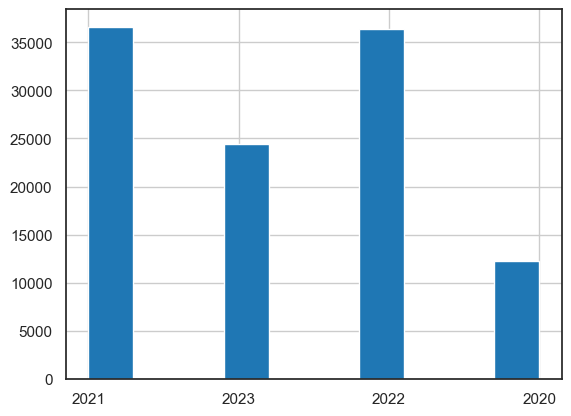

In [26]:
X_test_sub["Year"].hist()

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: >

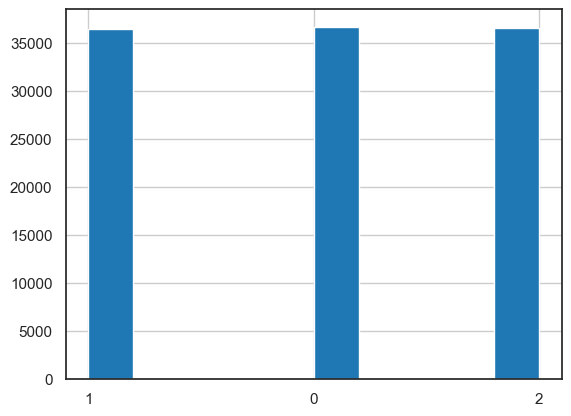

In [27]:
X_test_sub["Trisem"].hist()

In [28]:
df_GSCPI["Year"].value_counts()

2020    5
2021    5
2022    5
2023    3
Name: Year, dtype: int64

In [29]:
X_test["Trisem"].value_counts()

1    36037
0    35821
2    35624
Name: Trisem, dtype: int64

In [30]:
df_GSCPI["Trisem"].value_counts()

0    4
1    4
2    4
3    3
4    3
Name: Trisem, dtype: int64

In [31]:
var_onehot = ["Region","Product Life cycel status","Product  Line proxy","Year","Trisem"]
onehot_df_sub = X_test_sub[var_onehot]

onehot_enc = OneHotEncoder(handle_unknown="ignore",sparse_output=False)
onehot_enc.fit(onehot_df_sub)
onehot_features = onehot_enc.get_feature_names_out()

onehot_df_sub_t = pd.DataFrame(onehot_enc.transform(onehot_df_sub).astype("int"), columns=onehot_features)
onehot_df_sub_t

,Region_CHINA,Region_EAJP,Region_EUROPE,Region_NAM,Product Life cycel status_ACT,Product Life cycel status_EOL,Product Life cycel status_NPI,Product Life cycel status_RaMPDOWN,Product Line proxy_Product Line-1,Product Line proxy_Product Line-2,...,Product Line proxy_Product Line-4,Product Line proxy_Product Line-5,Product Line proxy_Product Line-6,Year_2020,Year_2021,Year_2022,Year_2023,Trisem_0,Trisem_1,Trisem_2
0,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
2,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
3,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
4,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109619,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
109620,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
109621,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
109622,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [32]:
X_test_sub_enc = pd.concat([X_test_sub.drop(columns=var_onehot).reset_index(drop=True), onehot_df_sub_t],axis=1)

In [33]:
len(y_pred_sub)

NameError: name 'y_pred_sub' is not defined

In [ ]:
X_test_sub_enc = X_test_sub_enc[fitcols_enc]
y_pred_sub = model_xgbr.predict(X_test_sub_enc.iloc[0:111391])

In [ ]:
df_sub = pd.DataFrame({"index": list(X_test_sub0["index"]) , "Month 4": list(y_pred_sub)},
                       columns = ["index", "Month 4"])

In [ ]:
len({"index": list(X_test_sub0["index"]) , "Month 4": list(y_pred_sub)}['index'])

In [ ]:
len(list(y_pred_sub))